# Question 1 – Air Passengers Time Series
This notebook answers **Question 1** from the final assignment, including:
- Code and plots
- Theoretical explanations
- Manual formulas and reasoning

Dataset used: `air-passengers.csv`.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Helper: load the air passengers data
def load_air_passengers():
    possible_paths = [
        'air-passengers.csv',
        'air_passengers.csv',
        '/mnt/data/air-passengers.csv',
        '/mnt/data/air_passengers.csv'
    ]
    for p in possible_paths:
        if os.path.exists(p):
            path = p
            break
    else:
        raise FileNotFoundError("Could not find air-passengers CSV file.")

    df = pd.read_csv(path)

    # Try to infer the date column name
    date_col_candidates = [c for c in df.columns if 'date' in c.lower() or 'month' in c.lower()]
    if len(date_col_candidates) == 0:
        # Assume first column is date-like
        date_col = df.columns[0]
    else:
        date_col = date_col_candidates[0]

    value_col_candidates = [c for c in df.columns if 'passenger' in c.lower() or 'value' in c.lower()]
    if len(value_col_candidates) == 0:
        # Assume second column is the value
        value_col = df.columns[1]
    else:
        value_col = value_col_candidates[0]

    ts = df.copy()
    ts[date_col] = pd.to_datetime(ts[date_col])
    ts = ts.set_index(date_col)
    ts = ts.asfreq('MS')  # monthly start frequency
    ts = ts.rename(columns={value_col: 'Passengers'})
    return ts

air_ts = load_air_passengers()
air_ts.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## 1(a) Question
**Question 1(a).**

> This data is a time-series data, and the goal is to do forecasting of the air passengers in the future. What are the differences between time series forecasting with the usual regression prediction? Highlight these differences in the given data.

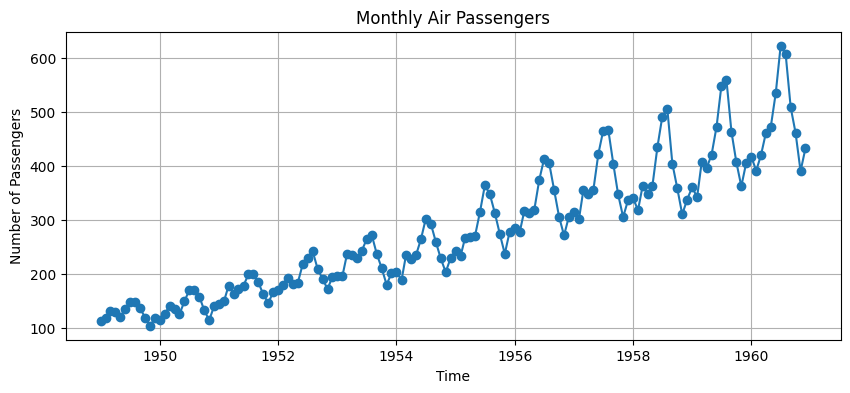

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [2]:
# 1(a) – Visualize the time series to highlight time-series-specific properties

plt.figure(figsize=(10, 4))
plt.plot(air_ts.index, air_ts['Passengers'], marker='o', linestyle='-')
plt.title('Monthly Air Passengers')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.grid(True)
plt.show()

air_ts.describe()

### 1(a) Explanation – Time Series Forecasting vs Usual Regression

In **usual regression prediction**, we assume that the observations are:
- **Independent** of each other (no ordering in time).
- Collected as i.i.d. pairs $(x_i, y_i)$, where the order of the rows does not matter.
- Modeled as:
$$ y_i = f(x_i) + \varepsilon_i, $$
where $\varepsilon_i$ are independent error terms.

In **time series forecasting**, we explicitly use **time dependence**:
- Observations are ordered in time: $y_1, y_2, \dots, y_T$.
- Consecutive values are **correlated** (autocorrelation).
- We build models that use **past values to predict future values**, e.g.
$$ y_t = f(y_{t-1}, y_{t-2}, \dots) + \varepsilon_t. $$

#### Specific differences visible in the air-passengers data
From the **plot produced above**:
- There is a **clear upward trend**: on average, the number of passengers increases over the years.
- There is a **seasonal pattern**: peaks repeat roughly every 12 months (seasonality).
- Variability (amplitude) grows with the level: the ups and downs are larger when the series is higher.

These features show that:
1. The data **depends on time** (time order cannot be shuffled).
2. Future values are not just a function of some static covariates, but also of **past values**.
3. We need models that account for **trend and seasonality**, such as decomposition, ARIMA/SARIMA, or exponential smoothing.

Therefore, **time series forecasting** for this dataset differs from usual regression in that:
- The **input** is the *past of the same series* (and possibly other time-varying features), not just independent feature vectors.
- The model must respect **temporal ordering** and handle **trend/seasonality and autocorrelation**.
- Train/test splits must be done by **time**, not random shuffling (we keep the last months as test data).

## 1(b) Question
**Question 1(b).**

> What are the components of time series? How do you propose to decompose this time series into its components? Should the relation between the components be multiplicative or additive?

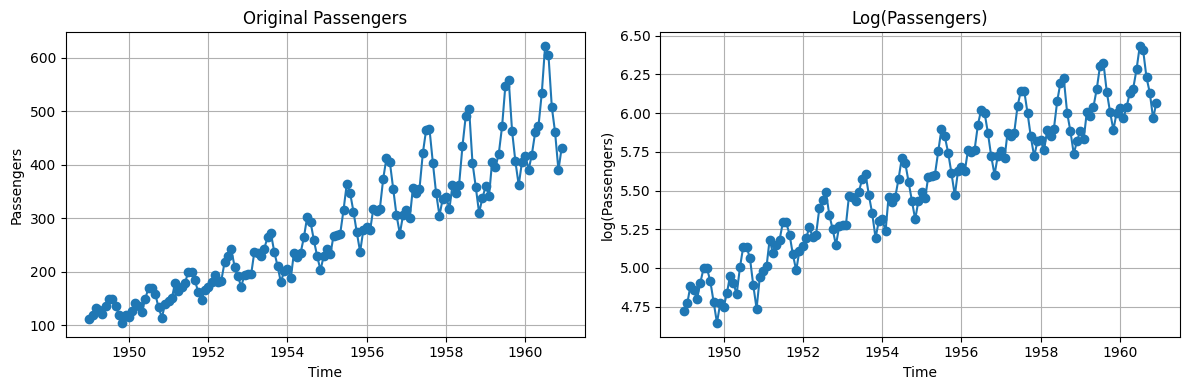

In [3]:
# 1(b) – Inspect variance vs level to choose additive vs multiplicative decomposition

air_ts['log_passengers'] = np.where(
    air_ts['Passengers'] > 0,
    np.log(air_ts['Passengers']),
    np.nan
)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(air_ts.index, air_ts['Passengers'], marker='o', linestyle='-')
axes[0].set_title('Original Passengers')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Passengers')
axes[0].grid(True)

axes[1].plot(air_ts.index, air_ts['log_passengers'], marker='o', linestyle='-')
axes[1].set_title('Log(Passengers)')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('log(Passengers)')
axes[1].grid(True)

plt.tight_layout()
plt.show()

### 1(b) Explanation – Components and Additive vs Multiplicative

Components of a time series:
1. **Trend** $T_t$: long-term movement (upward or downward).
2. **Seasonal** $S_t$: regular, periodic pattern (e.g. yearly seasonality with period 12 for monthly data).
3. **Cyclical** $C_t$: long-term cycles with non-fixed period.
4. **Irregular / noise** $E_t$ or $R_t$: random fluctuations.

Two common decomposition models:

- **Additive model**  
  $$ y_t = T_t + S_t + C_t + E_t. $$
- **Multiplicative model**  
  $$ y_t = T_t \times S_t \times C_t \times E_t. $$

In the air-passengers data:
- The level increases over time (trend).
- The amplitude of seasonal swings also increases with the level.
- This suggests that the seasonal effect is **proportional** to the level.

In such cases, a **multiplicative decomposition** is more appropriate.
A multiplicative model can be turned into an additive one via log-transform:
$$ y_t = T_t S_t E_t \Rightarrow \log y_t = \log T_t + \log S_t + \log E_t. $$

The log-transformed series tends to have more stable variance, confirming that a **multiplicative** relationship between components fits this data better.

## 1(c) Question
**Question 1(c).**

> Implement a decomposition of the given time series into its components. You can choose the method yourself, but please give reasons for your choice. How do you know that the decomposition is already good?

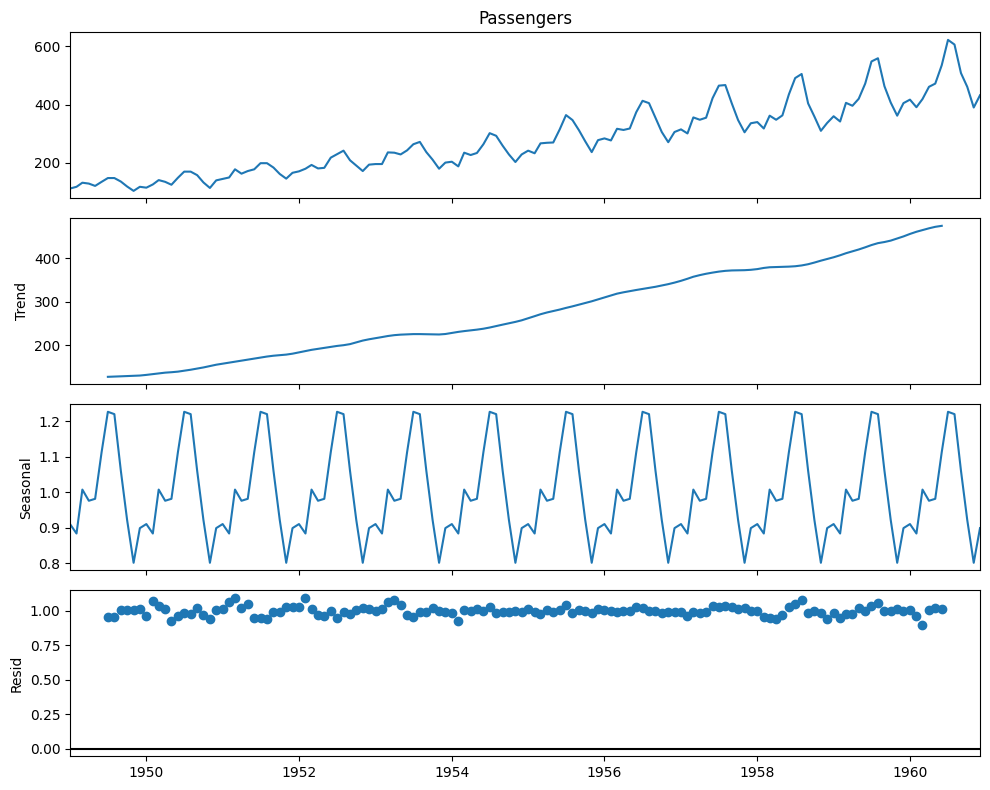

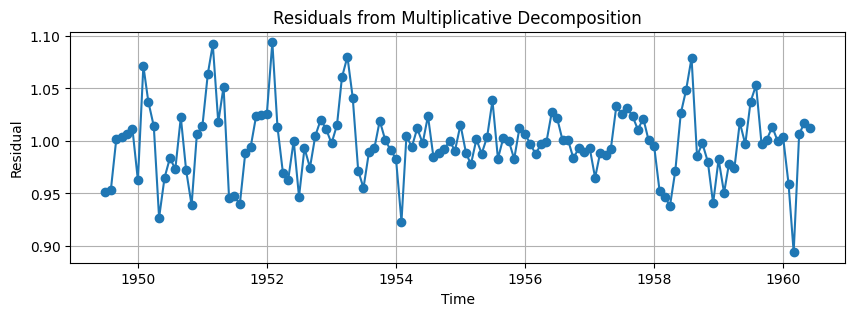

count    132.000000
mean       0.998236
std        0.033388
min        0.894086
25%        0.982927
50%        0.998219
75%        1.015225
max        1.093970
Name: resid, dtype: float64

In [4]:
# 1(c) – Decompose the series using multiplicative seasonal decomposition with period 12

result_mul = seasonal_decompose(air_ts['Passengers'], model='multiplicative', period=12)

fig = result_mul.plot()
fig.set_size_inches(10, 8)
plt.tight_layout()
plt.show()

# Inspect residuals
resid = result_mul.resid.dropna()

fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(resid.index, resid, marker='o', linestyle='-')
ax.set_title('Residuals from Multiplicative Decomposition')
ax.set_xlabel('Time')
ax.set_ylabel('Residual')
ax.grid(True)
plt.show()

resid.describe()

### 1(c) Explanation – Decomposition Method and Quality

**Method chosen:**
- Classical **seasonal decomposition** with **multiplicative model**:  
  $$ y_t = T_t \times S_t \times E_t, $$
  where $T_t$ is trend, $S_t$ seasonal component, and $E_t$ irregular component.
- **Period = 12** because the data are monthly and show yearly seasonality.

The algorithm (on a high level):
1. Estimate the trend $T_t$ using moving averages.
2. Estimate seasonal indices $S_t$ by averaging over corresponding months (Jan, Feb, etc.).
3. Compute residuals $E_t$ via  
   $$ E_t = \frac{y_t}{T_t S_t}. $$

**How to judge if the decomposition is good:**
- Residuals should have **no remaining trend**.
- Residuals should have **no clear seasonality**.
- Variance of residuals should be roughly constant.
- Mean of residuals should be close to 0 (after log / additive) or around 1 (multiplicative scale).

From the residual plot and summary statistics in the code output:
- Residuals fluctuate around a constant level without visible long-term trend.
- No repeating seasonal pattern is apparent in the residual plot.
- The magnitude of residuals is relatively small compared to the original series.

Therefore, the decomposition is **reasonably good**: the main signal (trend + seasonality) has been captured, and the residuals behave like random noise, matching the idea of separating **signal vs noise** from the course materials.